In [1]:
#!pip install ydata-profiling demoji nltk scikit-learn gensim  textblob spacy textstat transformers torch seaborn

In [2]:
import requests, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from ydata_profiling import ProfileReport
from textstat import flesch_reading_ease  # exploring text complixity
import nltk
from nltk.tokenize import word_tokenize
#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# classification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertTokenizer, AdamW

from torch.nn.utils.rnn import pad_sequence
import gc

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
df= pd.read_csv('../data/conversation_dataset.csv')
df.head(2)

,category,conversation,word_count,A_bad_intent,B_bad_intent,description
0,first participant in conversation is deceiving...,"A: Hey, I have something really important to t...",437,1.0,0.0,NaN
1,second participant in conversation is deceivin...,"A: Hey Sarah, I heard you recently went on a t...",368,0.0,1.0,NaN


In [4]:
def add_sep_token(conversation):
    token = '[SEP]' # the seperator token for BERT
    # split the conversation into turns using line breaks as delimiters
    turns = conversation.split('\n\n')
    turns_with_sep = [turn + token for turn in turns]
    return '[CLS]' + ''.join(turns_with_sep)
 
df['conversation'] = df['conversation'].apply(add_sep_token)

In [5]:
df.loc[0]['conversation']

"[CLS]A: Hey, I have something really important to tell you.[SEP]B: Sure, what's up?[SEP]A: You know that job opportunity I told you about last month? Well, I got it![SEP]B: Wow, that's amazing news! Congratulations![SEP]A: Thank you! I knew you'd be happy for me. B:ut here's the thing, the company wants me to relocate to another city for this position.[SEP]B: Oh, really? That's a big change. Are you considering it?[SEP]A: Well, I've been thinking about it, but I'm not entirely sure yet. There are a few things to consider, like the cost of living and leaving my family behind.[SEP]B: Of course, those are valid concerns. B:ut if it's a great opportunity, maybe it's worth taking the risk?[SEP]A: That's true, but I've been doing some research, and it seems like the company has a lot of internal issues. I'm starting to doubt if it's the right move for me.[SEP]B: Oh, really? That's concerning. What kind of issues are you talking about?[SEP]A: Well, I've heard rumors that they have financial 

In [6]:
df

,category,conversation,word_count,A_bad_intent,B_bad_intent,description
0,first participant in conversation is deceiving...,"[CLS]A: Hey, I have something really important...",437,1.0,0.0,NaN
1,second participant in conversation is deceivin...,"[CLS]A: Hey Sarah, I heard you recently went o...",368,0.0,1.0,NaN
2,both participants in conversation are deceivin...,"[CLS]A: Hey, how have you been? It's been a wh...",400,1.0,1.0,NaN
3,none of participants in conversation try to de...,[CLS]A: Hey Sarah! How was your weekend?[SEP]B...,494,0.0,0.0,NaN
4,first participant in conversation is deceiving...,[CLS]A: Hey there! How are you doing today?[SE...,534,1.0,0.0,NaN
...,...,...,...,...,...,...
95,none of participants in conversation try to de...,[CLS]A: Good morning! How are you today?[SEP]B...,714,0.0,0.0,NaN
96,first participant in conversation is deceiving...,"[CLS]A: Hey, how have you been? I was just thi...",560,1.0,0.0,NaN
97,second participant in conversation is deceivin...,"[CLS]A: Hey, I've been thinking about that inv...",724,0.0,1.0,NaN
98,both participants in conversation are deceivin...,"[CLS]A: Hey, long time no see! How have you be...",556,1.0,1.0,Both A and B were deceiving each other through...


---
### Preprocessing the combined dataset

In [7]:
#ProfileReport(df)

In [8]:
df[df['conversation'] == '']

,category,conversation,word_count,A_bad_intent,B_bad_intent,description


In [9]:
def text_preprocess(message):
    processed = []   
    for text in message:
        # replaace URLs
        text = re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)",' <URL>',text)        
        # Remove HTML/XML tags (if any)
        text = re.sub(r'<.*?>', '', text)
        # Remove punctuation and symbols (not for now)
        # text = re.sub(r'[^\w\s]', '', text) 
        # Remove numbers - not in this dataset!
        #text = re.sub(r'\d+', '', text)
        # Remove whitespaces (including new lines and tabs)
        text = text.strip().replace("\n", " ").replace("\r", " ").replace("\t", " ")
        
        processed.append(text)       
    return processed

In [10]:
df['conversation'] = text_preprocess(list(df['conversation']))
df

,category,conversation,word_count,A_bad_intent,B_bad_intent,description
0,first participant in conversation is deceiving...,"[CLS]A: Hey, I have something really important...",437,1.0,0.0,NaN
1,second participant in conversation is deceivin...,"[CLS]A: Hey Sarah, I heard you recently went o...",368,0.0,1.0,NaN
2,both participants in conversation are deceivin...,"[CLS]A: Hey, how have you been? It's been a wh...",400,1.0,1.0,NaN
3,none of participants in conversation try to de...,[CLS]A: Hey Sarah! How was your weekend?[SEP]B...,494,0.0,0.0,NaN
4,first participant in conversation is deceiving...,[CLS]A: Hey there! How are you doing today?[SE...,534,1.0,0.0,NaN
...,...,...,...,...,...,...
95,none of participants in conversation try to de...,[CLS]A: Good morning! How are you today?[SEP]B...,714,0.0,0.0,NaN
96,first participant in conversation is deceiving...,"[CLS]A: Hey, how have you been? I was just thi...",560,1.0,0.0,NaN
97,second participant in conversation is deceivin...,"[CLS]A: Hey, I've been thinking about that inv...",724,0.0,1.0,NaN
98,both participants in conversation are deceivin...,"[CLS]A: Hey, long time no see! How have you be...",556,1.0,1.0,Both A and B were deceiving each other through...


In [11]:
# number of conversation wth more than 512 words
long_conversations = sum([1 if len(i.split()) > 512 else 0 for i in df['conversation']])
long_conversations

45

In [12]:
df['conversation'].str.split().apply(lambda x : len(x)).describe()

count    100.000000
mean     505.030000
std      109.652109
min      272.000000
25%      437.750000
50%      496.000000
75%      566.000000
max      982.000000
Name: conversation, dtype: float64

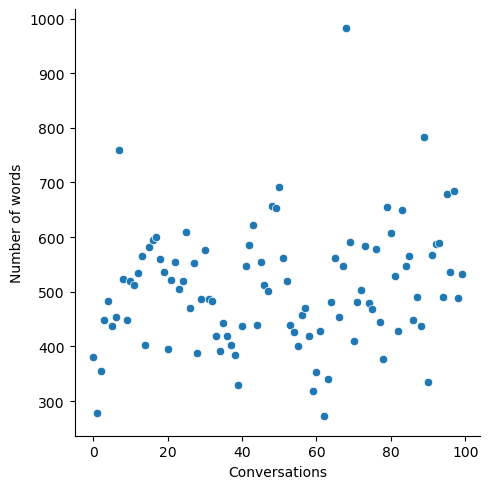

In [13]:
lensofc = [len(i.split()) for i in df['conversation']]
long_c_plot = sns.relplot(lensofc)
long_c_plot.set_ylabels("Number of words", clear_inner=False)
long_c_plot.set_xlabels("Conversations", clear_inner=False)

In [14]:
#df['conversation'].loc[0]

In [15]:
# find conversations with more than 5000 words
longs = [df.index[df['conversation'] == i].tolist()[0] for i in df['conversation'] if len(i.split()) > 4000]

In [16]:
longs

[]

In [17]:
#lets drop long conversations
df.drop(longs, axis=0, inplace=True)

---
### Preaper dataset for classification

<Axes: xlabel='A_bad_intent', ylabel='count'>

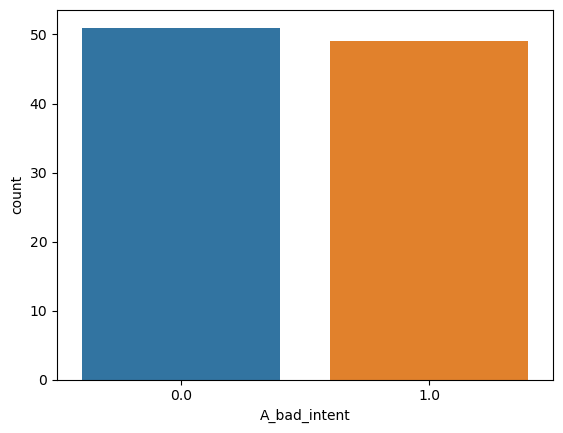

In [18]:
sns.countplot(data = df, x= df['A_bad_intent'])

<Axes: xlabel='B_bad_intent', ylabel='count'>

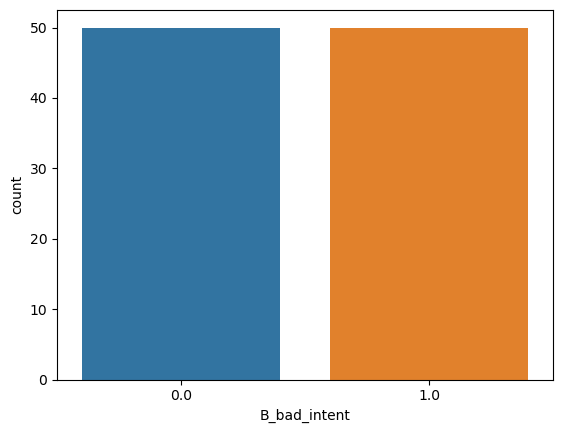

In [19]:
sns.countplot(data = df, x= df['B_bad_intent'])

#### balance the dataset or evalue the classification by weighted F1 score???

+ Normalization /scaling --> no need when using BERT
+ Shuffling --> shuffle=True in train_test_split


---
### Classification

In [20]:
# If there's a GPU available...
if torch.cuda.is_available():      
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('using the CPU')
    device = torch.device("cpu")

There are 1 GPU(s) available.
GPU: NVIDIA A100 80GB PCIe MIG 2g.20gb


---
Classification Model, to label each actor in the conversation

In [21]:
#@todo use BertForSequenceClassification instead of BertModel?

class ParticipantClassifier(nn.Module):
    def __init__(self, bert_model_name):
        super(ParticipantClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        # add a linear layer that maps the hidden state to two outputs, labels
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
 
    # input_ids, attention_mask are ouputs of tokenizer
    def forward(self, input_ids, attention_mask):
        # pass the input to the model
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # [CLS] token representation
        logits = self.classifier(pooled_output)
        # models confidence score for each calss
        logits_a = logits[:, 0]
        logits_b = logits[:, 1]
        return logits_a, logits_b

---
Tokenize and chunck conversations to segments with less than 512 tokens

In [22]:
class ConversationDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512, overlap=25): # overlap hardcoded
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.overlap = overlap
        
    def __len__(self):
        return len(self.data)
    
    def _tokenize(self, text):
        """Tokenize the text into overlapping segments."""
        tokens = self.tokenizer.encode(text, add_special_tokens=False)
        segments = []
        if len(tokens) > self.max_length - 2:  # for [CLS] and [SEP]
            start = 0
            while start < len(tokens):
                end = min(start + self.max_length-2, len(tokens))
                segment = tokens[start:end]
                #segment = [self.tokenizer.cls_token_id] + segment + [self.tokenizer.sep_token_id] # do I need this?
                #pad chunks up to the max length
                #padded_segments = segments + [self.tokenizer.pad_token_id] * (self.max_length - len(segments))  # do I need this?
                segments.append(segment)              
                # update the start and end of the next chunk
                start += self.max_length - self.overlap
       
        else:
            segments.append(tokens)
        return segments
    
    def __getitem__(self, idx):
        text = self.data[idx]['conversation']
        segments = self._tokenize(text)
        # process each segment
        inputs = [self.tokenizer.prepare_for_model(
                    seg,
                    add_special_tokens=False,  # I add special tokens manually
                    max_length=self.max_length,
                    padding='max_length',
                    return_tensors='pt',
                    truncation=True # 
                  ) for seg in segments]
        
        label_a = 1 if self.data[idx]['A_bad_intent'] == 1 else 0
        label_b = 1 if self.data[idx]['B_bad_intent'] == 1 else 0
        
        # return a list of segments, each with its own input_ids and attention_mask
        return {
            'segments': [{
                'input_ids': input['input_ids'].squeeze(),
                'attention_mask': input['attention_mask'].squeeze()
            } for input in inputs],
            'A_bad_intent': label_a,
            'B_bad_intent': label_b
        }

---

To ensure that each batch processed by the model has the same shape, collate_fn pads the sequences so that all data in a batch have the same length


In [23]:
def collate_fn(batch):
    """
    Custom collate function for handling batches of segmented conversations.
    """
    # lists to store the sequences and labels for all segments across all batch items
    input_ids_list = []
    attention_mask_list = []
    labels_a_list = []
    labels_b_list = []
 
    # list to store the segments for all batch items
    batch_segments = []
 
    for item in batch:
        # accumulate the labels for each item in the batch
        labels_a_list.append(item['A_bad_intent'])
        labels_b_list.append(item['B_bad_intent'])
 
        # collect segments from each item in the batch
        item_segments = []
        for segment in item['segments']:
            # for each segment, extract input_ids and attention_mask
            input_ids = segment['input_ids']
            attention_mask = segment['attention_mask']
 
            # append the segment's input_ids and attention_mask to the respective lists
            input_ids_list.append(input_ids)
            attention_mask_list.append(attention_mask)
 
            # also collect segments for this item
            item_segments.append({
                'input_ids': input_ids,
                'attention_mask': attention_mask
            })
 
        batch_segments.append(item_segments)
 
    # pad the sequences so that each sequence in the batch has the same length
    input_ids_padded = pad_sequence(input_ids_list, batch_first=True, padding_value=0)
    attention_mask_padded = pad_sequence(attention_mask_list, batch_first=True, padding_value=0)
    # convert labels lists to tensors
    labels_a = torch.tensor(labels_a_list)
    labels_b = torch.tensor(labels_b_list)
 
    # return the dictionary with padded 'input_ids', 'attention_mask' and 'segments'
    return {
        'segments': batch_segments,
        'input_ids': input_ids_padded,
        'attention_mask': attention_mask_padded,
        'A_bad_intent': labels_a,
        'B_bad_intent': labels_b
    }

---
To feed the text to BERT, first it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

In [24]:
#bert-base-uncased model has only lowercase letters!
# bert-base-cased: This model is case-sensitive: it makes a difference between english and English.
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False) 


In [25]:
#Train Test Validation split

# shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)
 
# define split sizes
train_size = int(0.7 * len(df)) # reduced train data to 50% to resolve cuda out of memory problem
val_size = int(0.15 * len(df))
 
# split the DataFrame
train_df = df[:train_size]
val_df = df[train_size:train_size + val_size]
test_df = df[train_size + val_size:]
 

In [26]:
train_data = train_df.to_dict('records')
val_data = val_df.to_dict('records')
test_data = test_df.to_dict('records')
#data
# Get the lists of sentences and their labels.
#data = df.conversation.values
#labels = df.target.values

In [27]:
# Print the original conversation.
print(' Original: ', train_data[30])
# Print that split into tokens.
tokenized_sample = tokenizer.tokenize(train_data[30]['conversation'])
print('Tokenized: ', tokenized_sample)
# Print mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenized_sample))

 Original:  {'category': 'both participants in conversation are deceiving each other', 'conversation': "[CLS]A: Hey, long time no see! How have you been?[SEP]B: I've been great, just got back from a business trip in Paris. How about you?[SEP]A: Oh, Paris sounds lovely. I've been doing well, just wrapped up an incredible project at work, actually. It's been a hectic few months.[SEP]B: That's awesome. What kind of project was it, if you don't mind me asking?[SEP]A: It was a high-profile marketing campaign. We were working with several international brands to launch a series of ads across different platforms. It required a lot of late nights, but it was worth it.[SEP]B: That sounds impressive. I've also been swamped. My trip to Paris was to secure a deal with a major French company. We're looking to expand our operations in Europe.[SEP]A: That's a big move! Congratulations. I'm sure that took a lot of negotiating skills and effort.[SEP]B: Thanks! It's all about who you know, you know? Spe

In [28]:
# batch and suffle the data

train_dataset = ConversationDataset(train_data, tokenizer, max_length=512)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True ,collate_fn=collate_fn)

val_dataset = ConversationDataset(val_data, tokenizer, max_length=512)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

test_dataset = ConversationDataset(test_data, tokenizer, max_length=512)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [29]:
train_dataset[30]

Token indices sequence length is longer than the specified maximum sequence length for this model (614 > 512). Running this sequence through the model will result in indexing errors


{'segments': [{'input_ids': tensor([  101,   138,   131,  4403,   117,  1263,  1159,  1185,  1267,   106,
            1731,  1138,  1128,  1151,   136,   102,   139,   131,   146,   112,
            1396,  1151,  1632,   117,  1198,  1400,  1171,  1121,   170,  1671,
            3868,  1107,  2123,   119,  1731,  1164,  1128,   136,   102,   138,
             131,  2048,   117,  2123,  3807,  9020,   119,   146,   112,  1396,
            1151,  1833,  1218,   117,  1198,  4293,  1146,  1126, 10965,  1933,
            1120,  1250,   117,  2140,   119,  1135,   112,   188,  1151,   170,
            1119, 11143,  1374,  1808,   119,   102,   139,   131,  1337,   112,
             188, 14918,   119,  1327,  1912,  1104,  1933,  1108,  1122,   117,
            1191,  1128,  1274,   112,   189,  1713,  1143,  4107,   136,   102,
             138,   131,  1135,  1108,   170,  1344,   118,  6168,  6213,  2322,
             119,  1284,  1127,  1684,  1114,  1317,  1835, 10915,  1106,  4286,
   

In [30]:
len(test_dataset.data)

15

In [31]:
# test spiliting tokens:
tokens = tokenizer.encode(train_data[30]['conversation'], add_special_tokens=False)
segments = []
print('len of tokens', len(tokens))
if len(tokens) > 510:  # for [CLS] and [SEP]
    start = 0
    while start < len(tokens):
        end = min(start + 510, len(tokens))
        print('end' , end)
        segment = tokens[start:end]
        #segment = [self.tokenizer.cls_token_id] + segment + [self.tokenizer.sep_token_id] # do I need this?
        #pad chunks up to the max length
        #padded_segments = segments + [self.tokenizer.pad_token_id] * (self.max_length - len(segments))  # do I need this?
        segments.append(segment)              
        # update the start and end of the next chunk
        start += 510 - 50
        print('start' , start)

else:
    segments.append(tokens)
print(segments)

len of tokens 614
end 510
start 460
end 614
start 920
[[101, 138, 131, 4403, 117, 1263, 1159, 1185, 1267, 106, 1731, 1138, 1128, 1151, 136, 102, 139, 131, 146, 112, 1396, 1151, 1632, 117, 1198, 1400, 1171, 1121, 170, 1671, 3868, 1107, 2123, 119, 1731, 1164, 1128, 136, 102, 138, 131, 2048, 117, 2123, 3807, 9020, 119, 146, 112, 1396, 1151, 1833, 1218, 117, 1198, 4293, 1146, 1126, 10965, 1933, 1120, 1250, 117, 2140, 119, 1135, 112, 188, 1151, 170, 1119, 11143, 1374, 1808, 119, 102, 139, 131, 1337, 112, 188, 14918, 119, 1327, 1912, 1104, 1933, 1108, 1122, 117, 1191, 1128, 1274, 112, 189, 1713, 1143, 4107, 136, 102, 138, 131, 1135, 1108, 170, 1344, 118, 6168, 6213, 2322, 119, 1284, 1127, 1684, 1114, 1317, 1835, 10915, 1106, 4286, 170, 1326, 1104, 17641, 1506, 1472, 6833, 119, 1135, 2320, 170, 1974, 1104, 1523, 6823, 117, 1133, 1122, 1108, 3869, 1122, 119, 102, 139, 131, 1337, 3807, 7757, 119, 146, 112, 1396, 1145, 1151, 16407, 1174, 119, 1422, 3868, 1106, 2123, 1108, 1106, 5343, 170, 2239, 

In [32]:
len(segments)

2

In [33]:
# len of all tokens after chunking, considering the overlap
all_len = 0
for i in segments:
    all_len += len(i)
print(all_len)

664


In [34]:
# remove variables after use and collect the garbage
def gc_colloctor(a, b) : 
    del a
    del b
    gc.collect()

In [35]:
def compute_metrics(model, dataloader, device):
    model.eval()  # put model in evaluation mode
    true_labels_a = []
    true_labels_b = []
    pred_labels_a = []
    pred_labels_b = []
 
    with torch.no_grad():  # no need to track gradients for evaluation
        for batch in dataloader:
            # initialize lists to store logits for all segments
            logits_a_list = []
            logits_b_list = []
            # aggregate logits for each segment in the batch
            for segments in batch['segments']:  # 'segments' is a list of dictionaries
                segment_logits_a = []
                segment_logits_b = []
                for segment in segments:
                    input_ids = segment['input_ids'].to(device)
                    attention_mask = segment['attention_mask'].to(device)
                    logits_a, logits_b = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
                    gc_colloctor(input_ids, attention_mask )
                    
                    segment_logits_a.append(logits_a)
                    segment_logits_b.append(logits_b)
                    gc_colloctor(logits_a, logits_b)
                    
                # combine the logits from all segments for the current example
                logits_a = torch.mean(torch.stack(segment_logits_a), dim=0)
                logits_b = torch.mean(torch.stack(segment_logits_b), dim=0)
                gc_colloctor(segment_logits_a, segment_logits_b)
                
                logits_a_list.append(logits_a)
                logits_b_list.append(logits_b)
                gc_colloctor(logits_a, logits_b)
 
            # convert logits to probabilities and then to binary predictions
            probs_a = torch.sigmoid(torch.cat(logits_a_list)).cpu().numpy()
            probs_b = torch.sigmoid(torch.cat(logits_b_list)).cpu().numpy()
            preds_a = (probs_a > 0.5).astype(int)
            preds_b = (probs_b > 0.5).astype(int)
 
            # collect the true labels and predictions
            true_labels_a.extend(batch['A_bad_intent'].numpy())
            true_labels_b.extend(batch['B_bad_intent'].numpy())
            pred_labels_a.extend(preds_a)
            pred_labels_b.extend(preds_b)
 
    accuracy_a = accuracy_score(true_labels_a, pred_labels_a)
    accuracy_b = accuracy_score(true_labels_b, pred_labels_b)
 
    return {
        'accuracy_a': accuracy_a,
        'accuracy_b': accuracy_b
    }

from https://www.kaggle.com/code/jaskaransingh/bert-fine-tuning-with-pytorch
    
Training:

+ Unpack our data inputs and labels
+ Load data onto the GPU for acceleration
+ Clear out the gradients calculated in the previous pass.
+ In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
+ Forward pass (feed input data through the network)
+ Backward pass (backpropagation)
+ Tell the network to update parameters with optimizer.step()
+ Track variables for monitoring progress

Evalution:

+ Unpack our data inputs and labels
+ Load data onto the GPU for acceleration
+ Forward pass (feed input data through the network)
+ Compute loss on our validation data and track variables for monitoring progress

In [36]:
# train and validation have a very similar proceess, lets put that in a function
def process_dataloader(model, dataloader, device, step, accumulation_steps = 0):
    num_batch = 0
    
    total_loss_a = 0
    total_loss_b = 0   
    true_labels_a = []
    true_labels_b = []
    pred_labels_a = []
    pred_labels_b = []
    
    for i, batch in enumerate(dataloader):
        torch.cuda.empty_cache()
        num_batch += 1
        print(num_batch , ' batch ...')
        #optimizer.zero_grad()  # zero the parameter gradients     
        
        # labels need to be of float type and reshaped to be of the same size as output logits
        labels_a = batch['A_bad_intent'].to(device).float()
        labels_b = batch['B_bad_intent'].to(device).float()
        # initialize variables to accumulate the logits for all segments
        logits_a_accumulated = []
        logits_b_accumulated = []
        
       # print('len of sengmentS' , len(batch['segments']))
        for segments in batch['segments']:  # now 'segments' is a list of dictionaries   
            torch.cuda.empty_cache()
            logits_a_list = []
            logits_b_list = []
            
            #print('len of sengment..' , len(segments))
            for segment in segments:
                torch.cuda.empty_cache()
                # segment is a dictionary as expected
                input_ids = segment['input_ids'].to(device)
                attention_mask = segment['attention_mask'].to(device)
               
                #print(f"Input IDs shape: {segment['input_ids'].shape}")
                #print(f"Attention Mask shape: {segment['attention_mask'].shape}")
                              
                # Always clear any previously calculated gradients before performing a
                # backward pass. PyTorch doesn't do this automatically because 
                # accumulating the gradients is "convenient while training RNNs". 
                # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
                model.zero_grad() 
                
                # forward pass for this segment
                logits_a, logits_b = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
                gc_colloctor(input_ids, attention_mask )
                #print('Model output:', logits_a, logits_b)
                
                logits_a_list.append(logits_a)
                logits_b_list.append(logits_b)
                gc_colloctor(logits_a, logits_b )
                            
            # aggregate the results for all segments of this item
            # here we use the mean of the logits, can choose other methods like max
            logits_a_item = torch.mean(torch.stack(logits_a_list), dim=0)
            logits_b_item = torch.mean(torch.stack(logits_b_list), dim=0)
            
            # zccumulate the logits for all items
            logits_a_accumulated.append(logits_a_item)
            logits_b_accumulated.append(logits_b_item)
            gc_colloctor(logits_a_item, logits_b_item )
            
        # Combine the accumulated logits for the whole batch
        logits_a = torch.cat(logits_a_accumulated, dim=0)
        logits_b = torch.cat(logits_b_accumulated, dim=0)
        #gc_colloctor(logits_b_accumulated, logits_a_accumulated )

        # compute loss for both outputs
        loss_a = loss_function(logits_a, labels_a)
        loss_b = loss_function(logits_b, labels_b)
        
        # convert logits to probabilities and then to binary predictions
        probs_a = torch.sigmoid(torch.cat(logits_a_accumulated)).cpu().detach().numpy()
        probs_b = torch.sigmoid(torch.cat(logits_b_accumulated)).cpu().detach().numpy()
        
        gc_colloctor(logits_a_list, logits_b_list )
        
        preds_a = (probs_a > 0.5).astype(int)
        preds_b = (probs_b > 0.5).astype(int)

        # collect the true labels and predictions
        true_labels_a.extend(batch['A_bad_intent'].numpy())
        true_labels_b.extend(batch['B_bad_intent'].numpy())
        pred_labels_a.extend(preds_a)
        pred_labels_b.extend(preds_b)
        # accumulate the loss
        total_loss_a += loss_a.item()
        total_loss_b += loss_b.item()
        gc_colloctor(logits_a, logits_b )
        
        loss = (loss_a + loss_b) / 2  # combine the losses 
        gc_colloctor(loss_a, loss_b )      
        
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        if (step == 'train'):
            loss = loss / accumulation_steps  # normalize our loss (if averaged)
            # backward pass and optimize
            loss.backward()      
            #optimizer.step()
            #perform optimization every 'accumulation_steps' iterations
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad() 
                       
        #total_loss += loss.item()  # accumulate the total loss
        
    # calculate average loss and accuracy for the epoch
    avg_loss_a = total_loss_a / len(dataloader)
    avg_loss_b = total_loss_b / len(dataloader)
    accuracy_a = accuracy_score(true_labels_a, pred_labels_a)
    accuracy_b = accuracy_score(true_labels_b, pred_labels_b)
    
    return avg_loss_a, avg_loss_b, accuracy_a, accuracy_b

In [37]:
def train_model(model, dataloader, device):
    accumulation_steps = 4  # should be adjust to  fit within avaialable memory limits
    model.train()  # set the model to training mode
    avg_loss_a, avg_loss_b, accuracy_a, accuracy_b = process_dataloader(model, dataloader, device,'train', accumulation_steps)  
    return  avg_loss_a, avg_loss_b, accuracy_a, accuracy_b

In [38]:
def evaluate_model(model, dataloader, device):
    model.eval()  # put model in evaluation mode, the dropout layers behave differently
 
    with torch.no_grad():  # no need to track gradients for evaluation
        avg_loss_a, avg_loss_b, accuracy_a, accuracy_b = process_dataloader(model, dataloader, device,'val') 
        
    return avg_loss_a, avg_loss_b, accuracy_a, accuracy_b

hyperparamethers from Appendix A.3 of the https://arxiv.org/pdf/1810.04805.pdf

+ Batch size: 16, 32 (here to make code run on low memory batch size is 4)
+ Learning rate (Adam): 5e-5, 3e-5, 2e-5
+ Number of epochs: 2, 3, 4

In [39]:
# Model & Optimizer
model = ParticipantClassifier('bert-base-cased')
optimizer = AdamW(model.parameters(), lr=5e-5) # , eps=1e-8 eps: a very small number to prevent any division by zero
loss_function = nn.BCEWithLogitsLoss()

In [40]:
model = model.to(device)

In [41]:
device

device(type='cuda')

In [42]:
train_dataloader.batch_size

8

In [43]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:    
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:    
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (28996, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [44]:
#@todo check oov words

In [45]:
#@todo improve metrics calculation -- check overfitting

In [46]:
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb=128'

In [47]:
#gives a readable summary of memory allocation and allows to figure the reason of CUDA running out of memory
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  423613 KB |  423613 KB |  423613 KB |       0 B  |
|       from large pool |  423116 KB |  423116 KB |  423116 KB |       0 B  |
|       from small pool |     497 KB |     497 KB |     497 KB |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |  423613 KB |  423613 KB |  423613 KB |       0 B  |
|       from large pool |  423116 KB |  423116 KB |  423116 KB |

In [48]:
epochs = 4 # 3 epochs?
test_metrics = []

validation_loss_a = []
validation_loss_b = []
validation_accuracy_a = []
validation_accuracy_b = []

train_loss_a = []
train_loss_b = []
training_accuracy_a = []
training_accuracy_b = []

for epoch in range(epochs):  
    
    print('epoch === ', epoch)
    
    print('Training ***')
    avg_train_loss_a, avg_train_loss_b, train_accuracy_a, train_accuracy_b = train_model(model, train_dataloader, device)
    print(f'Training Loss after epoch {epoch}: A : {avg_train_loss_a} B: {avg_train_loss_b}')
    print(f'Training Accuracy after epoch {epoch}: A : {train_accuracy_a} B: {train_accuracy_b}')
    train_loss_a.append(avg_train_loss_a)
    train_loss_b.append(avg_train_loss_b)
    training_accuracy_a.append(train_accuracy_a)
    training_accuracy_b.append(train_accuracy_b)
    
    print('Validation ***')
    avg_val_loss_a, avg_val_loss_b, val_accuracy_a, val_accuracy_b = evaluate_model(model, val_dataloader, device)
    print(f'Validation Loss after epoch {epoch}: A : {avg_val_loss_a} B: {avg_val_loss_b}')
    print(f'Validation Accuracy after epoch {epoch}: A : {val_accuracy_a} B: {val_accuracy_b}')
    validation_loss_a.append(avg_val_loss_a)
    validation_loss_b.append(avg_val_loss_b)
    validation_accuracy_a.append(val_accuracy_a)
    validation_accuracy_b.append(val_accuracy_b)

 
   

epoch ===  0
Training ***
1  batch ...
2  batch ...
3  batch ...
4  batch ...
5  batch ...
6  batch ...
7  batch ...
8  batch ...
9  batch ...
Training Loss after epoch 0: A : 0.6908532116148207 B: 0.8146895070870718
Training Accuracy after epoch 0: A : 0.5142857142857142 B: 0.5
Validation ***
1  batch ...
2  batch ...
Validation Loss after epoch 0: A : 0.7242561280727386 B: 0.7035457193851471
Validation Accuracy after epoch 0: A : 0.5333333333333333 B: 0.6
epoch ===  1
Training ***
1  batch ...
2  batch ...
3  batch ...
4  batch ...
5  batch ...
6  batch ...
7  batch ...
8  batch ...
9  batch ...
Training Loss after epoch 1: A : 0.693304161230723 B: 0.7559204995632172
Training Accuracy after epoch 1: A : 0.5571428571428572 B: 0.5
Validation ***
1  batch ...
2  batch ...
Validation Loss after epoch 1: A : 0.6597281098365784 B: 0.7181496918201447
Validation Accuracy after epoch 1: A : 0.5333333333333333 B: 0.4666666666666667
epoch ===  2
Training ***
1  batch ...
2  batch ...
3  batch .

In [49]:
 print('Test ***')
test_metrics = compute_metrics(model, test_dataloader, device)
print(test_metrics)

Test ***
{'accuracy_a': 0.3333333333333333, 'accuracy_b': 0.4}


In [50]:
#gives a readable summary of memory allocation and allows to figure the reason of CUDA running out of memory
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1714 MB |   13185 MB |    2011 GB |    2009 GB |
|       from large pool |    1712 MB |   13013 MB |    2005 GB |    2003 GB |
|       from small pool |       1 MB |     172 MB |       5 GB |       5 GB |
|---------------------------------------------------------------------------|
| Active memory         |    1714 MB |   13185 MB |    2011 GB |    2009 GB |
|       from large pool |    1712 MB |   13013 MB |    2005 GB |

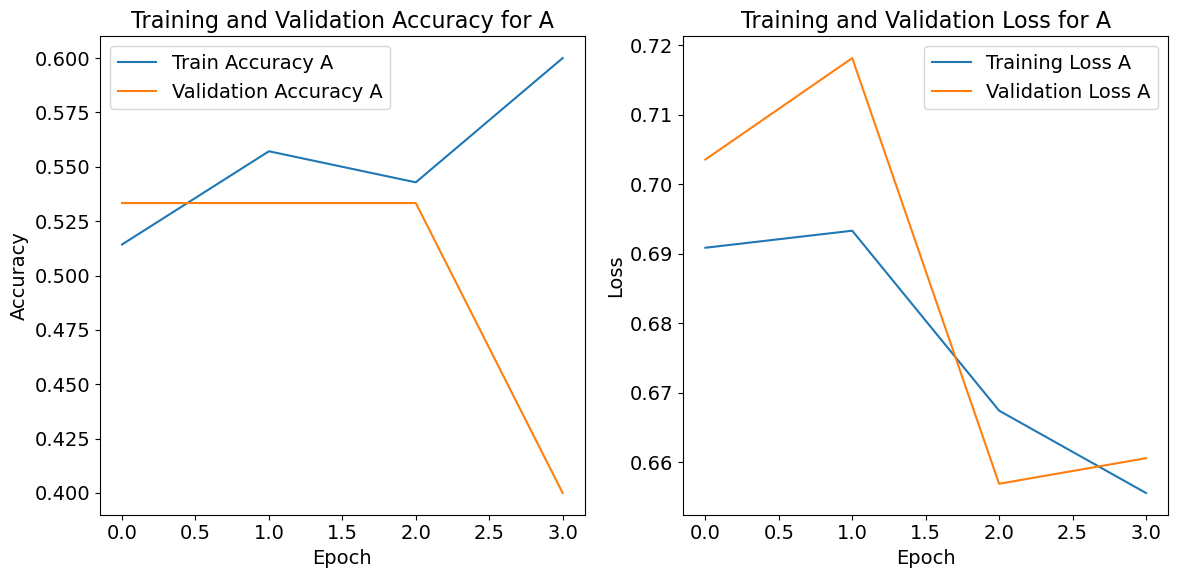

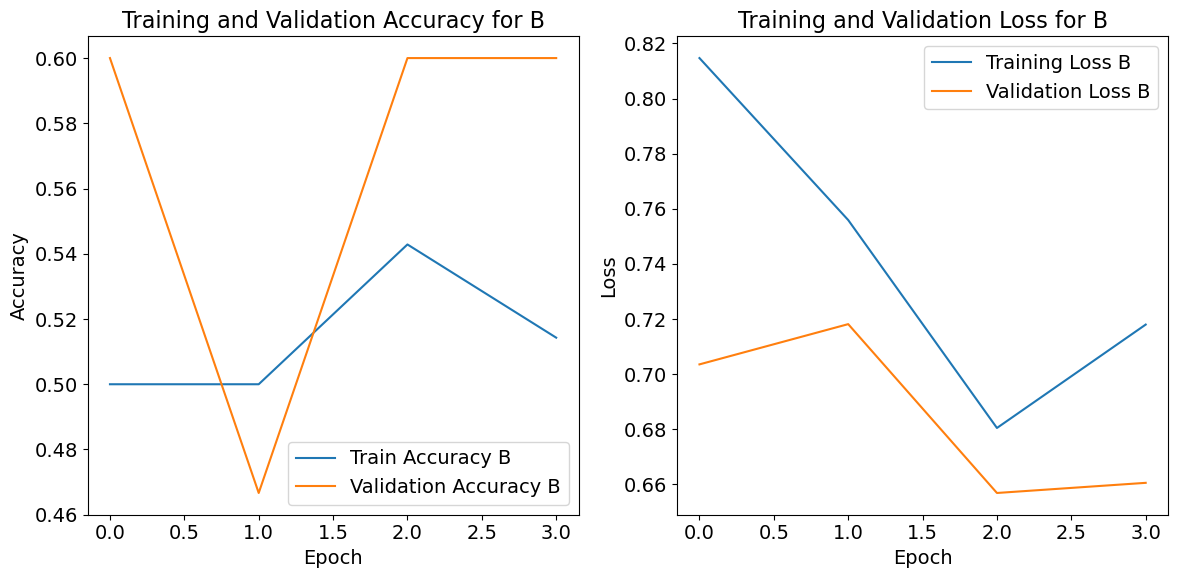

In [54]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), training_accuracy_a, label='Train Accuracy A')
plt.plot(range(epochs), validation_accuracy_a, label='Validation Accuracy A')
plt.xlabel('Epoch', fontsize=14)  
plt.ylabel('Accuracy', fontsize=14)
plt.title(f'Training and Validation Accuracy for A', fontsize=16)
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_loss_a, label='Training Loss A')
plt.plot(range(epochs), validation_loss_b, label='Validation Loss A')
plt.xlabel('Epoch', fontsize=14)  
plt.ylabel('Loss', fontsize=14)
plt.title(f'Training and Validation Loss for A', fontsize=16)
plt.legend(fontsize=14)

plt.tight_layout()

# Save the plot as an image
plt.savefig('accuracy_and_loss_plot_A.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

#############
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), training_accuracy_b, label='Train Accuracy B')
plt.plot(range(epochs), validation_accuracy_b, label='Validation Accuracy B')
plt.xlabel('Epoch', fontsize=14)  
plt.ylabel('Accuracy', fontsize=14)
plt.title(f'Training and Validation Accuracy for B', fontsize=16)
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_loss_b, label='Training Loss B')
plt.plot(range(epochs), validation_loss_b, label='Validation Loss B')
plt.xlabel('Epoch', fontsize=14)  
plt.ylabel('Loss', fontsize=14)
plt.title(f'Training and Validation Loss for B', fontsize=16)
plt.legend(fontsize=14)

plt.tight_layout()

# Save the plot as an image
plt.savefig('accuracy_and_loss_plot_B.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

The above plot shows  that while the model is learning to perform well on the training data, it is not generalizing well to new, unseen data,
which could be an indication of overfitting.

---
#### To do list:

2. Improve chunking tokens --> chunck tokens bsed on each turn in the conversation and include prevouse and later turns for each chunck
3. improve model performance + plot the results   
4. Try other models(DistilBERT, ALBERT, RoBerta)
5. Evaluate model on diplomacy dataset

